In [1]:
#from google.colab import drive
#drive.mount ('/content/drive')

In [2]:
import numpy as np
import matplotlib as matplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn import (
    linear_model, metrics, pipeline, preprocessing, model_selection
)

from sklearn.preprocessing import scale, LabelEncoder
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

#!pip install lifelines
from lifelines import CoxPHFitter

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

import sklearn.linear_model as skl_lm

from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

#Import data

In [3]:
raw_data = pd.read_csv("compas-analysis-master/compas-scores-two-years.csv")
print(raw_data.shape)
raw_data.columns

(7214, 53)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [4]:
raw_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:
#raw_data.isna().sum()

Short comparison to other CSVs

In [6]:
parsed_data = pd.read_csv("compas-analysis-master/cox-parsed.csv")
print(parsed_data.shape)
parsed_data.columns 

(13419, 52)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

how is this dataset diffrent: number of rows is bigger (names double if diffrent), but columns are the same

In [7]:
parsed_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0
1,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,334,961,0
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0
4,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,63,64,1


# Data Cleaning

In [8]:
df = raw_data.loc[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != "O") &
    (raw_data['score_text'] != "N/A")
]
len(df)

6172

In [9]:
df[["is_recid", "two_year_recid"]]
df['is_recid'].equals(df['two_year_recid'])

False

# Exploratory Analysis

In [10]:
# Number of people per race
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [11]:
# Race by ccore text
pd.crosstab(df['score_text'],df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
score_text,,,,,,
High,845,3,223,47,4,22
Low,1346,24,1407,368,3,273
Medium,984,4,473,94,4,48


<AxesSubplot:title={'center':'Score Text by Race'}, ylabel='Race'>

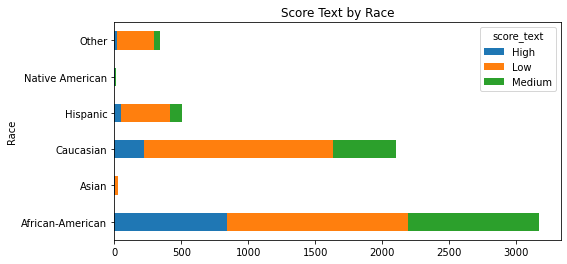

In [12]:
score_text_by_race = df.groupby(['race','score_text'], sort = True)['id'].size()
score_text_by_race.unstack().plot(
    kind = "barh", 
    title = "Score Text by Race",
    ylabel = "Score Text",
    xlabel = "Race",
    figsize = (8,4),
    stacked = True
)

In [13]:
# Create a dataframe with only the african-americans, caucasians and hispanics
df_three = df.loc[df['race'].isin(["African-American","Caucasian","Hispanic"])]

In [14]:
# Calculate the total and proportions of score texts in each race group
score_text_by_race_prop= df_three.groupby(['race', 'score_text']).agg({'score_text': 'count'})
score_text_by_race_prop['prop'] = score_text_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))
score_text_by_race_prop

score_text       prop
race             score_text                       
African-American High               845  26.614173
                 Low               1346  42.393701
                 Medium             984  30.992126
Caucasian        High               223  10.603899
                 Low               1407  66.904422
                 Medium             473  22.491679
Hispanic         High                47   9.233792
                 Low                368  72.298625
                 Medium              94  18.467583

In [15]:
# Mean decile scores per race
df_three.groupby('race')['decile_score'].mean()

race
African-American    5.276850
Caucasian           3.635283
Hispanic            3.383104
Name: decile_score, dtype: float64

Text(0, 0.5, 'Count')

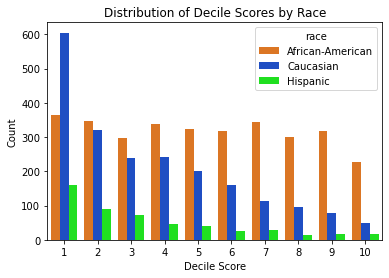

In [16]:
# Distribution of decile scores per race
sns.countplot(
    data = df_three,
    x = 'decile_score',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

# COMPAS Score Prediction

# Reproduction of COMPAS analysis

In [17]:
# Create a dataframe with only the african-americans and caucasians
df_binary = df.loc[df['race'].isin(["African-American","Caucasian"])]

In [18]:
df_binary.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0


### Distribution of COMPAS score among whtites and blacks (plot) & compare with Distribution of real recidivism among whites and blacks (plot)

In [19]:
# Calculate the total and proportions of decile scores per race
decile_score_by_race_prop= df_binary.groupby(['race', 'decile_score']).agg({'decile_score': 'count'})
decile_score_by_race_prop['prop'] = decile_score_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

In [20]:
# Calculate the total and proportions of recidivates per race
is_recid_by_race_prop= df_binary.groupby(['race', 'is_recid']).agg({'decile_score': 'count'})
is_recid_by_race_prop['prop'] = is_recid_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

Text(0, 0.5, 'Count')

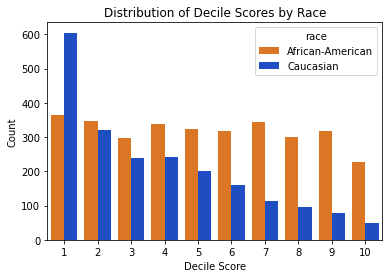

In [21]:
sns.countplot(
    data = df_binary,
    x = 'decile_score',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

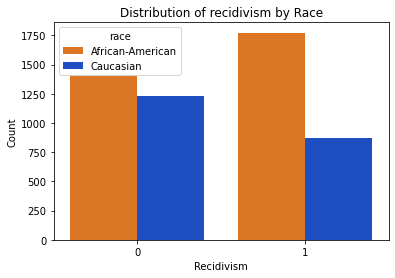

In [22]:
sns.countplot(
    data = df_binary,
    x = 'is_recid',
    hue = 'race',
    palette = ["#F97306","#0343DF","#00FF00"]
)
plt.title('Distribution of recidivism by Race')
plt.xlabel('Recidivism')
plt.ylabel('Count')

### Most predictive factors in logistic model (with controlling for other factors) for score

In [23]:
# As in the ProPublica article the score text "medium" and "high" are labeled "high", the score text "low" stays the same in order to have binary score texts
df['score_text_binary'] = df['score_text'].replace(['Medium'], 'High')

In [24]:
# In order to be able to use this labeling in the regression, the labels need to be numerical
df['score_text_binary']= df['score_text_binary'].replace(['High'], 1)
df['score_text_binary']= df['score_text_binary'].replace(['Low'], 0)

ProPublica Claim: Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior (when adjusted for other variables, because in their table they show 0.47).

In [25]:
# Logistic Regression: Where the intercept doesn't take the right value automatically, we set it via the reference. 
# The Intercept shall be: white, male, aged between 25-45
est = smf.logit('score_text_binary ~ C(age_cat) + C(race, Treatment(reference="Caucasian")) + C(sex,Treatment(reference="Male")) + priors_count + C(c_charge_degree) + two_year_recid', df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      score_text_binary   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Sun, 12 Feb 2023   Pseudo R-squ.:                  0.2729
Time:                        10:59:16   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Interc

In [26]:
# Controlling for other variables by taking the Intercept to have a control and a treatment group
ControlgGroup= np.exp(-1.5255)/(1+ np.exp(-1.5255))
FinalClaim= np.exp(0.4772)/(1- ControlgGroup + (ControlgGroup * np.exp(0.4772)))
FinalClaim
# Interpretation: Black people are 45% more likely to be assesed as high risk

1.452825407001621

## Cox analysis : in progress


In [27]:
# Cleaning as ProPublica article
parsed_filter= parsed_data.loc[
    (parsed_data['score_text'] != 'N/A') &
    (parsed_data['end'] > parsed_data['start'])]


parsed_not_duplicates= parsed_filter.drop_duplicates(subset='id')

# Drop variables not dummyfiables
parsed_not_duplicates= parsed_not_duplicates.drop(['name','first','last','compas_screening_date'], axis=1)

print(parsed_not_duplicates.shape)
parsed_not_duplicates.columns

(10325, 48)


Index(['id', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count',
       'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

In [28]:
# Create dummy variables 
for feature in parsed_not_duplicates.columns:
    if parsed_not_duplicates[feature].dtype=="object":
      le = LabelEncoder()
      le.fit(parsed_not_duplicates.columns)
      parsed_not_duplicates[feature] = le.fit_transform(parsed_not_duplicates[feature].astype(str)) #le.fit_transform(df_train[feature].astype(str))

print(parsed_not_duplicates.head())

   id  sex   dob  age  age_cat  race  juv_fel_count  decile_score  \
0   1    1    77   69        1     5              0             1   
2   3    1  3660   34        0     0              0             3   
3   4    1  5886   24        2     0              0             4   
5   5    1  6326   23        2     0              0             8   
6   6    1  2203   43        0     5              0             1   

   juv_misd_count  juv_other_count  ...  v_type_of_assessment  v_decile_score  \
0               0                0  ...                     0               1   
2               0                0  ...                     0               1   
3               0                1  ...                     0               3   
5               1                0  ...                     0               6   
6               0                0  ...                     0               1   

   v_score_text  v_screening_date  in_custody  out_custody  priors_count.1  \
0             1     

In [29]:
#parsed_not_duplicates.isna().sum()

In [30]:
# Fit the Cox
cph = CoxPHFitter()
cph = cph.fit(parsed_not_duplicates, duration_col = 'end', event_col = 'event')
cph.print_summary()

TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

# Reproduce Northpointe's rebuttal
AUC Results in Sample A
Sample A consists of pretrial defendants with complete case
records who have at least two years of follow-up time. The PP authors use
Sample A to fit reverse logistic regressions predicting the“Not Low”Risk Level.
Subsets of Sample A are used for tests of the GRRS (n=6,172) and the VRRS
(n=4,020). (p.4 and 16 Northpointe)

In [31]:
# Convert categorical features to numeric levels
for feature in df.columns:
    if df[feature].dtype=="object":
      le = LabelEncoder()
      le.fit(df.columns)
      df[feature] = le.fit_transform(df[feature].astype(str)) #le.fit_transform(df_train[feature].astype(str))

print(df.head())

   id  name  first  last  compas_screening_date  sex   dob  age  age_cat  \
0   1  4216   1615  1454                    202    1    43   69        1   
1   3  3437   1285   897                     26    1  2280   34        0   
2   4  1709    651  2509                    102    1  3905   24        2   
5   7  3939   1545  2189                    307    1  1196   44        0   
6   8  1749    661  2707                    388    1  1447   41        0   

   race  ...  v_score_text  v_screening_date  in_custody  out_custody  \
0     5  ...             1               202         549          553   
1     0  ...             1                26          27           34   
2     0  ...             1               102         165          165   
5     5  ...             1               307         331          332   
6     2  ...             1               388         452          470   

   priors_count.1  start  end  event  two_year_recid  score_text_binary  
0               0      0  327 

In [32]:
# Dataframe of target: binary score text
y = df.score_text_binary

In [33]:
# We take the same features as ProPublica did for their logistic regression. This is what Northpointe did as well (Sample A)
X = df[['age_cat','race', 'sex', 'priors_count','c_charge_degree', 'two_year_recid']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.11, random_state = 94)

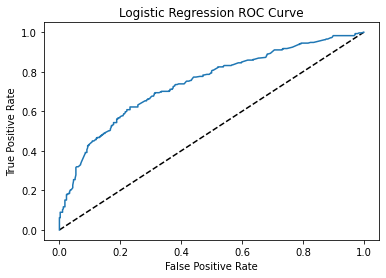

The total AUC is  0.7419049137350764


In [34]:
# Fit logisti regression
clf2 = skl_lm.LogisticRegression(solver='newton-cg')
clf2.fit(X_train,y_train)

# Predict y probability 
y_pred = clf2.predict_proba(X_test) 
y_pred_prob = y_pred[:,1]

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

#AUC
print('The total AUC is ', roc_auc_score(y_test, y_pred_prob))

#Their AUC for sample A is 0.71 #Why is this one diffrent than the output?

# Reproduce Washington Post 1 analysis

###Code taken from https://allendowney.github.io/RecidivismCaseStudy/02_calibration.html
###Is it ok that we take it? (Sofi)

In [35]:
#Anh please rewrite 
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


In [36]:
download('https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/' +
         'master/utils.py')

In [37]:
from utils import decorate
from utils import make_matrix
from utils import compute_metrics
from utils import error_rates

In [38]:
def calibration_curve(df):
    """Fraction in each risk group charged with another crime.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

###The plot below shows an approximate equality between white and black defendants. This holds for every one of Northpointe’s 10 risk levels.

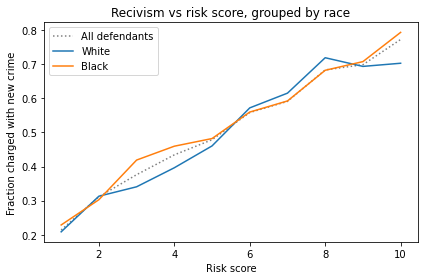

In [39]:
cal_all = calibration_curve(raw_data)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

white = (raw_data['race'] == 'Caucasian')
cal_white = calibration_curve(raw_data[white])
cal_white.plot(label='White')

black = (raw_data['race'] == 'African-American')
cal_black = calibration_curve(raw_data[black])
cal_black.plot(label='Black')

decorate(xlabel='Risk score',
         ylabel='Fraction charged with new crime',
         title='Recivism vs risk score, grouped by race')

###This plot shows that we can’t be fair in both ways at the same time

In [40]:
# Create Datafram with only african-americans
df_black = raw_data.loc[raw_data['race'].isin(["African-American"])]
df_black.shape

(3696, 53)

In [41]:
# Create dataframe with only caucasians
df_white = raw_data.loc[raw_data['race'].isin(["Caucasian"])]
df_white.shape

(2454, 53)

In [42]:
# Per race:
# Relabel the score text as before but not with numerical
# Devide dataframe in recidivated and non-recidivated
df_white['score_text'] = raw_data['score_text'].replace(['Medium'], 'Medium/High').replace(['High'], 'Medium/High')
df_white_recid = df_white.loc[df_white['is_recid'].isin([1])]
df_white_nonrecid = df_white.loc[df_white['is_recid'].isin([0])]

df_black['score_text'] = raw_data['score_text'].replace(['Medium'], 'Medium/High').replace(['High'], 'Medium/High')
df_black_recid = df_black.loc[df_black['is_recid'].isin([1])]
df_black_nonrecid = df_black.loc[df_black['is_recid'].isin([0])]

<function matplotlib.pyplot.show(close=None, block=None)>

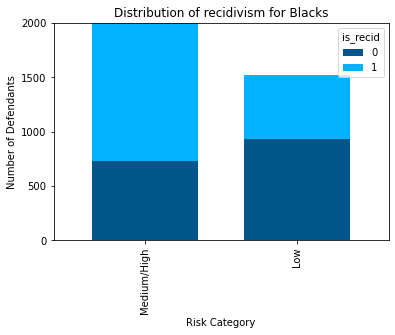

In [43]:
# Trying with 2 subplots for stacking
df_plot = df_black.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
ax = df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Blacks',
    color=["#00558A","#00B2FF"])
plt.gca().invert_xaxis()
ax.set_xlabel("Risk Category")
ax.set_ylabel("Number of Defendants")
plt.ylim([0, 2000])
plt.yticks([0, 500, 1000, 1500, 2000])

plt.show

In [ ]:
df_plot = df_white.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Whites',
    color=["#00558A","#00B2FF"])
plt.gca().invert_xaxis()
ax.set_xlabel("Risk Category")
ax.set_ylabel("Number of Defendants")
plt.ylim([0, 2000])
plt.yticks([0, 500, 1000, 1500, 2000])

plt.show

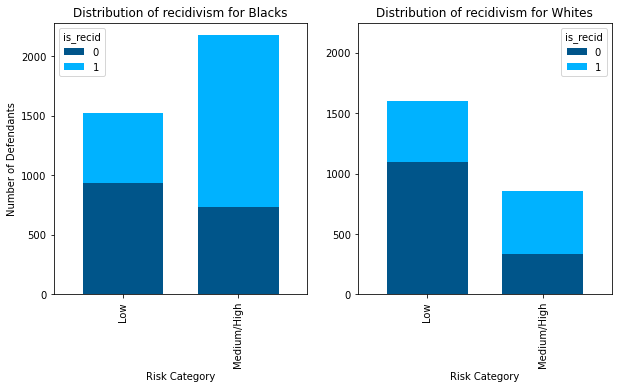

In [44]:
# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot first dataframe
df_plot = df_black.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Blacks',
    color=["#00558A","#00B2FF"],
    ax=ax1)
ax1.set_xlabel("Risk Category")
ax1.set_ylabel("Number of Defendants")
#ax1.invert_xaxis()
plt.ylim([0, 2250])
plt.yticks([0, 500, 1000, 1500, 2000])

# Plot second dataframe
df_plot = df_white.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Whites',
    color=["#00558A","#00B2FF"],
    ax=ax2)
ax2.set_xlabel("Risk Category")
ax2.set_ylabel("")
#ax2.invert_xaxis()
plt.ylim([0, 2250])
plt.yticks([0, 500, 1000, 1500, 2000])

# Show plot
plt.show()


# Directly / indirectly Model recidivism / Tree based model for ?


directly(classification) --> random forest?
*  predict recidivism
*  predict violent recidivism

indirectly (regression)
*  predict COMPAS scores for recidivism
*  predict COMPAS scores for violent recidivism


# Explore connections between local and global explanations from machine learning model with multiple linear regression

# 1 or more questions from the following:

1. Is there a single correct definition of fairness ? Are multiple types of fairness compatible ?
2. Are interpretable models just as accurate as black box machine learning models for predicting recidivism ?
Can complex models be as transparent as simple ones ? How do I communicate nonlinear dependencies ?
3. How do I explain a single prediction, i.e. how do I decompose it into feature driven components ? What
would be useful global feature attribution methods ?
4. How does the "base rate" affect the tradeoffs ?
5. How can I find relevant interactions ?
6. Counterfactuals: what extra value do they bring and what assumptions are made ?


# Are the COMPAS risk scales racially biased against blacks?


"Particular characteristics of non-black defendants in Broward County, Florida are the reason why some of the previous analyses found COMPAS biased" (stated as an assumption in file:///C:/Users/joana/Documents/Nextcloud/03%20Karriere/2022%20WS%2023%20BIPM%20HWR/1%20-%20Data%20Science/project/reading/Chapter%2010%20Story%20COMPAS_%20recidivism%20reloaded%20_%20XAI%20Stories.pdf page 16)

Check Ceteris Paribus (which freezes all othe factors) and then it's still biased for African Americans (same, page 20)



could they controll for race (interrelating with age and number for arrests for example)?

### Is the Articel / model of COMPAS good?

"Particular characteristics of non-black defendants in Broward County, Florida are the reason why some of the previous analyses found COMPAS biased" (stated as an assumption in file:///C:/Users/joana/Documents/Nextcloud/03%20Karriere/2022%20WS%2023%20BIPM%20HWR/1%20-%20Data%20Science/project/reading/Chapter%2010%20Story%20COMPAS_%20recidivism%20reloaded%20_%20XAI%20Stories.pdf page 16)

Check Ceteris Paribus (which freezes all othe factors) and then it's still biased for African Americans (same, page 20)

could they controll for race (interrelating with age and number for arrests for example)?

